In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_30 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.mortality.final_model_loss_train_mortality import *
from model.final_model.mortality.final_model_mortality import PatientOutcomeModel
from model.retnet.autoencoder_v5_retnet import  TSAutoencoder
from model.final_model.mortality.plot import *


import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()



In [2]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)

## load the inbalanced dataset sampler
labels_train = [int(dataset_train[i][5]) for i in range(len(dataset_train))]

train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)

# build the dataloader
train_loader = DataLoader( dataset_train,batch_size=128,sampler=train_sampler,collate_fn=collate_fn )

val_loader = DataLoader( dataset_val,batch_size=32,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=32,shuffle=False,collate_fn=collate_fn )
train_loader_p = DataLoader(dataset_train, batch_size=128, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [3]:
flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [4]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/mortality/resampled_30_datasampler"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"
model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=20, save_dir=save_path, 
            gamma=100, beta=150, kappa=200,  eta=1, 
            patience = 5 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint E1] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E1] Calc Global P:  12%|█▏        | 2/17 [00:00<00:05,  2.54it/s]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E1] Calc Global P:  18%|█▊        | 3/17 [00:01<00:04,  3.03it/s]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E1] Calc Global P:  24%|██▎       | 4/17 [00:01<00:04,  3.03it/s]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E1] Calc Global P:  29%|██▉       | 5/17 [00:01<00:03,  3.32it/s]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E1] Calc Global P:  35%|███▌      | 6/17 [00:03<00:08,  1.25it/s]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E1] Calc Global P:  41%|████      | 7/17 [00:03<00:06,  1.61it/s]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E1] Calc Global P:  47%|████▋     | 8/17 [00:03<00:04,  1.97it/s]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E1] Calc Global P:  53%|█████▎    | 9/17 [00:04<00:03,  2.32it/s]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E1] Calc Global P:  59%|█████▉    | 10/17 [00:04<00:02,  2.61it/s]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E1] Calc Global P:  65%|██████▍   | 11/17 [00:09<00:10,  1.73s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E1] Calc Global P:  71%|███████   | 12/17 [00:13<00:12,  2.60s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E1] Calc Global P:  76%|███████▋  | 13/17 [00:18<00:12,  3.14s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E1] Calc Global P:  82%|████████▏ | 14/17 [00:23<00:10,  3.65s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E1] Calc Global P:  88%|████████▊ | 15/17 [00:27<00:07,  3.89s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E1] Calc Global P:  94%|█████████▍| 16/17 [00:31<00:03,  3.80s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1664])
99 --- torch.Size([2, 1664])
675 torch.Size([2, 1664])
EDGE_INDEX: torch.Size([2, 1664])		LOOP_INDEX: torch.Size([2, 675])
241 --- torch.Size([2, 1664])
99 --- torch.Size([2, 1664])
675 torch.Size([2, 1664])
EDGE_INDEX: torch.Size([2, 1664])		LOOP_INDEX: torch.Size([2, 675])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
730 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 730])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
730 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 730])
241 --- torch.Size([2, 1802])
99 --- torch.Size([2, 1802])
676 torch.Size([2, 1802])
EDGE_INDEX: torch.Size([2, 1802])		LOOP_INDEX: torch.Size([2, 676])
241 --- torch.Size([2, 1802])
99 --- torch.Size([2, 1802])
676 torch.Size([2, 1802])
EDGE_INDEX: torch.Size([2, 1802])		LOOP_INDEX: torch.Size([2, 676])
241 --- torch.Size([2, 1834])
99 --- torch.Size([2, 1834])
715 torch.Size([2, 1834

[Joint E2] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E2] Calc Global P:   6%|▌         | 1/17 [00:05<01:21,  5.09s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E2] Calc Global P:  12%|█▏        | 2/17 [00:09<01:13,  4.91s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E2] Calc Global P:  18%|█▊        | 3/17 [00:14<01:07,  4.81s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E2] Calc Global P:  24%|██▎       | 4/17 [00:18<00:58,  4.53s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E2] Calc Global P:  29%|██▉       | 5/17 [00:23<00:53,  4.49s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E2] Calc Global P:  35%|███▌      | 6/17 [00:26<00:45,  4.16s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E2] Calc Global P:  41%|████      | 7/17 [00:31<00:42,  4.29s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E2] Calc Global P:  47%|████▋     | 8/17 [00:35<00:38,  4.32s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E2] Calc Global P:  53%|█████▎    | 9/17 [00:40<00:35,  4.40s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E2] Calc Global P:  59%|█████▉    | 10/17 [00:45<00:31,  4.57s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E2] Calc Global P:  65%|██████▍   | 11/17 [00:49<00:27,  4.60s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E2] Calc Global P:  71%|███████   | 12/17 [00:53<00:22,  4.45s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E2] Calc Global P:  76%|███████▋  | 13/17 [00:57<00:17,  4.26s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E2] Calc Global P:  82%|████████▏ | 14/17 [01:02<00:13,  4.40s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E2] Calc Global P:  88%|████████▊ | 15/17 [01:06<00:08,  4.32s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E2] Calc Global P:  94%|█████████▍| 16/17 [01:09<00:04,  4.05s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1626])
99 --- torch.Size([2, 1626])
663 torch.Size([2, 1626])
EDGE_INDEX: torch.Size([2, 1626])		LOOP_INDEX: torch.Size([2, 663])
241 --- torch.Size([2, 1626])
99 --- torch.Size([2, 1626])
663 torch.Size([2, 1626])
EDGE_INDEX: torch.Size([2, 1626])		LOOP_INDEX: torch.Size([2, 663])
241 --- torch.Size([2, 1628])
99 --- torch.Size([2, 1628])
666 torch.Size([2, 1628])
EDGE_INDEX: torch.Size([2, 1628])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1628])
99 --- torch.Size([2, 1628])
666 torch.Size([2, 1628])
EDGE_INDEX: torch.Size([2, 1628])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1612])
99 --- torch.Size([2, 1612])
666 torch.Size([2, 1612])
EDGE_INDEX: torch.Size([2, 1612])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1612])
99 --- torch.Size([2, 1612])
666 torch.Size([2, 1612])
EDGE_INDEX: torch.Size([2, 1612])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1598])
99 --- torch.Size([2, 1598])
658 torch.Size([2, 1598

[Joint E3] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E3] Calc Global P:   6%|▌         | 1/17 [00:05<01:21,  5.12s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E3] Calc Global P:  12%|█▏        | 2/17 [00:09<01:14,  4.95s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E3] Calc Global P:  18%|█▊        | 3/17 [00:14<01:06,  4.72s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E3] Calc Global P:  24%|██▎       | 4/17 [00:18<00:56,  4.38s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E3] Calc Global P:  29%|██▉       | 5/17 [00:22<00:52,  4.42s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E3] Calc Global P:  35%|███▌      | 6/17 [00:25<00:41,  3.76s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E3] Calc Global P:  41%|████      | 7/17 [00:30<00:41,  4.17s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E3] Calc Global P:  47%|████▋     | 8/17 [00:34<00:37,  4.20s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E3] Calc Global P:  53%|█████▎    | 9/17 [00:39<00:34,  4.31s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E3] Calc Global P:  59%|█████▉    | 10/17 [00:43<00:30,  4.36s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E3] Calc Global P:  65%|██████▍   | 11/17 [00:48<00:26,  4.48s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E3] Calc Global P:  71%|███████   | 12/17 [00:52<00:22,  4.43s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E3] Calc Global P:  76%|███████▋  | 13/17 [00:56<00:17,  4.30s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E3] Calc Global P:  82%|████████▏ | 14/17 [01:01<00:13,  4.51s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E3] Calc Global P:  88%|████████▊ | 15/17 [01:05<00:08,  4.37s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E3] Calc Global P:  94%|█████████▍| 16/17 [01:09<00:04,  4.13s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1778])
99 --- torch.Size([2, 1778])
697 torch.Size([2, 1778])
EDGE_INDEX: torch.Size([2, 1778])		LOOP_INDEX: torch.Size([2, 697])
241 --- torch.Size([2, 1778])
99 --- torch.Size([2, 1778])
697 torch.Size([2, 1778])
EDGE_INDEX: torch.Size([2, 1778])		LOOP_INDEX: torch.Size([2, 697])
241 --- torch.Size([2, 1584])
99 --- torch.Size([2, 1584])
666 torch.Size([2, 1584])
EDGE_INDEX: torch.Size([2, 1584])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1584])
99 --- torch.Size([2, 1584])
666 torch.Size([2, 1584])
EDGE_INDEX: torch.Size([2, 1584])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1906])
99 --- torch.Size([2, 1906])
719 torch.Size([2, 1906])
EDGE_INDEX: torch.Size([2, 1906])		LOOP_INDEX: torch.Size([2, 719])
241 --- torch.Size([2, 1906])
99 --- torch.Size([2, 1906])
719 torch.Size([2, 1906])
EDGE_INDEX: torch.Size([2, 1906])		LOOP_INDEX: torch.Size([2, 719])
241 --- torch.Size([2, 1646])
99 --- torch.Size([2, 1646])
680 torch.Size([2, 1646

[Joint E4] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E4] Calc Global P:   6%|▌         | 1/17 [00:04<01:09,  4.37s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E4] Calc Global P:  12%|█▏        | 2/17 [00:08<01:05,  4.37s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E4] Calc Global P:  18%|█▊        | 3/17 [00:13<01:01,  4.41s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E4] Calc Global P:  24%|██▎       | 4/17 [00:16<00:53,  4.13s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E4] Calc Global P:  29%|██▉       | 5/17 [00:21<00:50,  4.25s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E4] Calc Global P:  35%|███▌      | 6/17 [00:24<00:43,  3.91s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E4] Calc Global P:  41%|████      | 7/17 [00:29<00:41,  4.13s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E4] Calc Global P:  47%|████▋     | 8/17 [00:33<00:38,  4.27s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E4] Calc Global P:  53%|█████▎    | 9/17 [00:38<00:34,  4.32s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E4] Calc Global P:  59%|█████▉    | 10/17 [00:42<00:30,  4.40s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E4] Calc Global P:  65%|██████▍   | 11/17 [00:47<00:27,  4.54s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E4] Calc Global P:  71%|███████   | 12/17 [00:51<00:22,  4.44s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E4] Calc Global P:  76%|███████▋  | 13/17 [00:55<00:17,  4.29s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E4] Calc Global P:  82%|████████▏ | 14/17 [01:00<00:13,  4.57s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E4] Calc Global P:  88%|████████▊ | 15/17 [01:05<00:09,  4.59s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E4] Calc Global P:  94%|█████████▍| 16/17 [01:09<00:04,  4.37s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1500])
99 --- torch.Size([2, 1500])
625 torch.Size([2, 1500])
EDGE_INDEX: torch.Size([2, 1500])		LOOP_INDEX: torch.Size([2, 625])
241 --- torch.Size([2, 1500])
99 --- torch.Size([2, 1500])
625 torch.Size([2, 1500])
EDGE_INDEX: torch.Size([2, 1500])		LOOP_INDEX: torch.Size([2, 625])
241 --- torch.Size([2, 1666])
99 --- torch.Size([2, 1666])
686 torch.Size([2, 1666])
EDGE_INDEX: torch.Size([2, 1666])		LOOP_INDEX: torch.Size([2, 686])
241 --- torch.Size([2, 1666])
99 --- torch.Size([2, 1666])
686 torch.Size([2, 1666])
EDGE_INDEX: torch.Size([2, 1666])		LOOP_INDEX: torch.Size([2, 686])
241 --- torch.Size([2, 1586])
99 --- torch.Size([2, 1586])
665 torch.Size([2, 1586])
EDGE_INDEX: torch.Size([2, 1586])		LOOP_INDEX: torch.Size([2, 665])
241 --- torch.Size([2, 1586])
99 --- torch.Size([2, 1586])
665 torch.Size([2, 1586])
EDGE_INDEX: torch.Size([2, 1586])		LOOP_INDEX: torch.Size([2, 665])
241 --- torch.Size([2, 1368])
99 --- torch.Size([2, 1368])
591 torch.Size([2, 1368

[Joint E5] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E5] Calc Global P:   6%|▌         | 1/17 [00:04<01:07,  4.25s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E5] Calc Global P:  12%|█▏        | 2/17 [00:08<01:05,  4.37s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E5] Calc Global P:  18%|█▊        | 3/17 [00:12<00:59,  4.25s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E5] Calc Global P:  24%|██▎       | 4/17 [00:16<00:51,  3.99s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E5] Calc Global P:  29%|██▉       | 5/17 [00:20<00:49,  4.14s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E5] Calc Global P:  35%|███▌      | 6/17 [00:24<00:43,  3.92s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E5] Calc Global P:  41%|████      | 7/17 [00:29<00:42,  4.24s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E5] Calc Global P:  47%|████▋     | 8/17 [00:33<00:36,  4.10s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E5] Calc Global P:  53%|█████▎    | 9/17 [00:37<00:33,  4.15s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E5] Calc Global P:  59%|█████▉    | 10/17 [00:42<00:30,  4.40s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E5] Calc Global P:  65%|██████▍   | 11/17 [00:46<00:26,  4.39s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E5] Calc Global P:  71%|███████   | 12/17 [00:51<00:22,  4.44s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E5] Calc Global P:  76%|███████▋  | 13/17 [00:55<00:17,  4.28s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E5] Calc Global P:  82%|████████▏ | 14/17 [00:59<00:13,  4.41s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E5] Calc Global P:  88%|████████▊ | 15/17 [01:04<00:09,  4.51s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E5] Calc Global P:  94%|█████████▍| 16/17 [01:08<00:04,  4.24s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1774])
99 --- torch.Size([2, 1774])
709 torch.Size([2, 1774])
EDGE_INDEX: torch.Size([2, 1774])		LOOP_INDEX: torch.Size([2, 709])
241 --- torch.Size([2, 1774])
99 --- torch.Size([2, 1774])
709 torch.Size([2, 1774])
EDGE_INDEX: torch.Size([2, 1774])		LOOP_INDEX: torch.Size([2, 709])
241 --- torch.Size([2, 1812])
99 --- torch.Size([2, 1812])
697 torch.Size([2, 1812])
EDGE_INDEX: torch.Size([2, 1812])		LOOP_INDEX: torch.Size([2, 697])
241 --- torch.Size([2, 1812])
99 --- torch.Size([2, 1812])
697 torch.Size([2, 1812])
EDGE_INDEX: torch.Size([2, 1812])		LOOP_INDEX: torch.Size([2, 697])
241 --- torch.Size([2, 1562])
99 --- torch.Size([2, 1562])
669 torch.Size([2, 1562])
EDGE_INDEX: torch.Size([2, 1562])		LOOP_INDEX: torch.Size([2, 669])
241 --- torch.Size([2, 1562])
99 --- torch.Size([2, 1562])
669 torch.Size([2, 1562])
EDGE_INDEX: torch.Size([2, 1562])		LOOP_INDEX: torch.Size([2, 669])
241 --- torch.Size([2, 1488])
99 --- torch.Size([2, 1488])
639 torch.Size([2, 1488

[Joint E6] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E6] Calc Global P:   6%|▌         | 1/17 [00:04<01:07,  4.24s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E6] Calc Global P:  12%|█▏        | 2/17 [00:08<01:06,  4.43s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E6] Calc Global P:  18%|█▊        | 3/17 [00:13<01:02,  4.44s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E6] Calc Global P:  24%|██▎       | 4/17 [00:17<00:55,  4.27s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E6] Calc Global P:  29%|██▉       | 5/17 [00:21<00:52,  4.34s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E6] Calc Global P:  35%|███▌      | 6/17 [00:24<00:42,  3.83s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E6] Calc Global P:  41%|████      | 7/17 [00:29<00:41,  4.11s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E6] Calc Global P:  47%|████▋     | 8/17 [00:33<00:37,  4.20s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E6] Calc Global P:  53%|█████▎    | 9/17 [00:38<00:34,  4.35s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E6] Calc Global P:  59%|█████▉    | 10/17 [00:43<00:31,  4.50s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E6] Calc Global P:  65%|██████▍   | 11/17 [00:47<00:27,  4.53s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E6] Calc Global P:  71%|███████   | 12/17 [00:52<00:22,  4.54s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E6] Calc Global P:  76%|███████▋  | 13/17 [00:56<00:17,  4.42s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E6] Calc Global P:  82%|████████▏ | 14/17 [01:00<00:13,  4.42s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E6] Calc Global P:  88%|████████▊ | 15/17 [01:05<00:08,  4.33s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E6] Calc Global P:  94%|█████████▍| 16/17 [01:08<00:04,  4.16s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1496])
99 --- torch.Size([2, 1496])
642 torch.Size([2, 1496])
EDGE_INDEX: torch.Size([2, 1496])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1496])
99 --- torch.Size([2, 1496])
642 torch.Size([2, 1496])
EDGE_INDEX: torch.Size([2, 1496])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1702])
99 --- torch.Size([2, 1702])
684 torch.Size([2, 1702])
EDGE_INDEX: torch.Size([2, 1702])		LOOP_INDEX: torch.Size([2, 684])
241 --- torch.Size([2, 1702])
99 --- torch.Size([2, 1702])
684 torch.Size([2, 1702])
EDGE_INDEX: torch.Size([2, 1702])		LOOP_INDEX: torch.Size([2, 684])
241 --- torch.Size([2, 1692])
99 --- torch.Size([2, 1692])
684 torch.Size([2, 1692])
EDGE_INDEX: torch.Size([2, 1692])		LOOP_INDEX: torch.Size([2, 684])
241 --- torch.Size([2, 1692])
99 --- torch.Size([2, 1692])
684 torch.Size([2, 1692])
EDGE_INDEX: torch.Size([2, 1692])		LOOP_INDEX: torch.Size([2, 684])
241 --- torch.Size([2, 1710])
99 --- torch.Size([2, 1710])
678 torch.Size([2, 1710

[Joint E7] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E7] Calc Global P:   6%|▌         | 1/17 [00:04<01:09,  4.37s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E7] Calc Global P:  12%|█▏        | 2/17 [00:08<01:05,  4.35s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E7] Calc Global P:  18%|█▊        | 3/17 [00:13<01:00,  4.33s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E7] Calc Global P:  24%|██▎       | 4/17 [00:16<00:54,  4.19s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E7] Calc Global P:  29%|██▉       | 5/17 [00:21<00:52,  4.35s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E7] Calc Global P:  35%|███▌      | 6/17 [00:25<00:44,  4.08s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E7] Calc Global P:  41%|████      | 7/17 [00:30<00:43,  4.39s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E7] Calc Global P:  47%|████▋     | 8/17 [00:34<00:40,  4.48s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E7] Calc Global P:  53%|█████▎    | 9/17 [00:39<00:36,  4.57s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E7] Calc Global P:  59%|█████▉    | 10/17 [00:45<00:34,  4.86s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E7] Calc Global P:  65%|██████▍   | 11/17 [00:50<00:30,  5.04s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E7] Calc Global P:  71%|███████   | 12/17 [00:54<00:23,  4.79s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E7] Calc Global P:  76%|███████▋  | 13/17 [00:58<00:18,  4.55s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E7] Calc Global P:  82%|████████▏ | 14/17 [01:03<00:14,  4.69s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E7] Calc Global P:  88%|████████▊ | 15/17 [01:07<00:08,  4.45s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E7] Calc Global P:  94%|█████████▍| 16/17 [01:11<00:04,  4.24s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1532])
99 --- torch.Size([2, 1532])
656 torch.Size([2, 1532])
EDGE_INDEX: torch.Size([2, 1532])		LOOP_INDEX: torch.Size([2, 656])
241 --- torch.Size([2, 1532])
99 --- torch.Size([2, 1532])
656 torch.Size([2, 1532])
EDGE_INDEX: torch.Size([2, 1532])		LOOP_INDEX: torch.Size([2, 656])
241 --- torch.Size([2, 1648])
99 --- torch.Size([2, 1648])
692 torch.Size([2, 1648])
EDGE_INDEX: torch.Size([2, 1648])		LOOP_INDEX: torch.Size([2, 692])
241 --- torch.Size([2, 1648])
99 --- torch.Size([2, 1648])
692 torch.Size([2, 1648])
EDGE_INDEX: torch.Size([2, 1648])		LOOP_INDEX: torch.Size([2, 692])
241 --- torch.Size([2, 1738])
99 --- torch.Size([2, 1738])
696 torch.Size([2, 1738])
EDGE_INDEX: torch.Size([2, 1738])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1738])
99 --- torch.Size([2, 1738])
696 torch.Size([2, 1738])
EDGE_INDEX: torch.Size([2, 1738])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1736])
99 --- torch.Size([2, 1736])
687 torch.Size([2, 1736

[Joint E8] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E8] Calc Global P:   6%|▌         | 1/17 [00:04<01:15,  4.74s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E8] Calc Global P:  12%|█▏        | 2/17 [00:09<01:08,  4.56s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E8] Calc Global P:  18%|█▊        | 3/17 [00:13<01:03,  4.56s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E8] Calc Global P:  24%|██▎       | 4/17 [00:18<00:57,  4.46s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E8] Calc Global P:  29%|██▉       | 5/17 [00:22<00:55,  4.62s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E8] Calc Global P:  35%|███▌      | 6/17 [00:26<00:47,  4.29s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E8] Calc Global P:  41%|████      | 7/17 [00:31<00:44,  4.45s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E8] Calc Global P:  47%|████▋     | 8/17 [00:35<00:40,  4.49s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E8] Calc Global P:  53%|█████▎    | 9/17 [00:40<00:36,  4.54s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E8] Calc Global P:  59%|█████▉    | 10/17 [00:45<00:32,  4.70s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E8] Calc Global P:  65%|██████▍   | 11/17 [00:50<00:27,  4.62s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E8] Calc Global P:  71%|███████   | 12/17 [00:54<00:22,  4.55s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E8] Calc Global P:  76%|███████▋  | 13/17 [00:58<00:17,  4.38s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E8] Calc Global P:  82%|████████▏ | 14/17 [01:03<00:13,  4.55s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E8] Calc Global P:  88%|████████▊ | 15/17 [01:07<00:08,  4.46s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E8] Calc Global P:  94%|█████████▍| 16/17 [01:11<00:04,  4.20s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 2006])
99 --- torch.Size([2, 2006])
721 torch.Size([2, 2006])
EDGE_INDEX: torch.Size([2, 2006])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 2006])
99 --- torch.Size([2, 2006])
721 torch.Size([2, 2006])
EDGE_INDEX: torch.Size([2, 2006])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1706])
99 --- torch.Size([2, 1706])
698 torch.Size([2, 1706])
EDGE_INDEX: torch.Size([2, 1706])		LOOP_INDEX: torch.Size([2, 698])
241 --- torch.Size([2, 1706])
99 --- torch.Size([2, 1706])
698 torch.Size([2, 1706])
EDGE_INDEX: torch.Size([2, 1706])		LOOP_INDEX: torch.Size([2, 698])
241 --- torch.Size([2, 1704])
99 --- torch.Size([2, 1704])
669 torch.Size([2, 1704])
EDGE_INDEX: torch.Size([2, 1704])		LOOP_INDEX: torch.Size([2, 669])
241 --- torch.Size([2, 1704])
99 --- torch.Size([2, 1704])
669 torch.Size([2, 1704])
EDGE_INDEX: torch.Size([2, 1704])		LOOP_INDEX: torch.Size([2, 669])
241 --- torch.Size([2, 1714])
99 --- torch.Size([2, 1714])
693 torch.Size([2, 1714

[Joint E9] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E9] Calc Global P:   6%|▌         | 1/17 [00:04<01:19,  4.95s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E9] Calc Global P:  12%|█▏        | 2/17 [00:09<01:10,  4.73s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E9] Calc Global P:  18%|█▊        | 3/17 [00:14<01:04,  4.64s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E9] Calc Global P:  24%|██▎       | 4/17 [00:17<00:56,  4.32s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E9] Calc Global P:  29%|██▉       | 5/17 [00:22<00:53,  4.45s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E9] Calc Global P:  35%|███▌      | 6/17 [00:26<00:45,  4.16s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E9] Calc Global P:  41%|████      | 7/17 [00:30<00:43,  4.34s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E9] Calc Global P:  47%|████▋     | 8/17 [00:35<00:39,  4.34s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E9] Calc Global P:  53%|█████▎    | 9/17 [00:39<00:34,  4.32s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E9] Calc Global P:  59%|█████▉    | 10/17 [00:44<00:30,  4.42s/it]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E9] Calc Global P:  65%|██████▍   | 11/17 [00:48<00:26,  4.48s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E9] Calc Global P:  71%|███████   | 12/17 [00:53<00:22,  4.45s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E9] Calc Global P:  76%|███████▋  | 13/17 [00:56<00:16,  4.20s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E9] Calc Global P:  82%|████████▏ | 14/17 [01:01<00:13,  4.40s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E9] Calc Global P:  88%|████████▊ | 15/17 [01:05<00:08,  4.37s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E9] Calc Global P:  94%|█████████▍| 16/17 [01:09<00:04,  4.13s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1724])
99 --- torch.Size([2, 1724])
693 torch.Size([2, 1724])
EDGE_INDEX: torch.Size([2, 1724])		LOOP_INDEX: torch.Size([2, 693])
241 --- torch.Size([2, 1724])
99 --- torch.Size([2, 1724])
693 torch.Size([2, 1724])
EDGE_INDEX: torch.Size([2, 1724])		LOOP_INDEX: torch.Size([2, 693])
241 --- torch.Size([2, 1762])
99 --- torch.Size([2, 1762])
687 torch.Size([2, 1762])
EDGE_INDEX: torch.Size([2, 1762])		LOOP_INDEX: torch.Size([2, 687])
241 --- torch.Size([2, 1762])
99 --- torch.Size([2, 1762])
687 torch.Size([2, 1762])
EDGE_INDEX: torch.Size([2, 1762])		LOOP_INDEX: torch.Size([2, 687])
241 --- torch.Size([2, 1576])
99 --- torch.Size([2, 1576])
669 torch.Size([2, 1576])
EDGE_INDEX: torch.Size([2, 1576])		LOOP_INDEX: torch.Size([2, 669])
241 --- torch.Size([2, 1576])
99 --- torch.Size([2, 1576])
669 torch.Size([2, 1576])
EDGE_INDEX: torch.Size([2, 1576])		LOOP_INDEX: torch.Size([2, 669])
241 --- torch.Size([2, 1680])
99 --- torch.Size([2, 1680])
643 torch.Size([2, 1680

[Joint E10] Calc Global P:   0%|          | 0/17 [00:00<?, ?it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E10] Calc Global P:   6%|▌         | 1/17 [00:04<01:12,  4.55s/it]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E10] Calc Global P:  12%|█▏        | 2/17 [00:09<01:08,  4.56s/it]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E10] Calc Global P:  18%|█▊        | 3/17 [00:13<01:00,  4.36s/it]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E10] Calc Global P:  24%|██▎       | 4/17 [00:17<00:55,  4.25s/it]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E10] Calc Global P:  29%|██▉       | 5/17 [00:22<00:53,  4.46s/it]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E10] Calc Global P:  35%|███▌      | 6/17 [00:25<00:44,  4.03s/it]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E10] Calc Global P:  41%|████      | 7/17 [00:29<00:41,  4.14s/it]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E10] Calc Global P:  47%|████▋     | 8/17 [00:34<00:37,  4.21s/it]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E10] Calc Global P:  59%|█████▉    | 10/17 [00:42<00:30,  4.29s/it]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E10] Calc Global P:  65%|██████▍   | 11/17 [00:47<00:26,  4.39s/it]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E10] Calc Global P:  71%|███████   | 12/17 [00:51<00:21,  4.37s/it]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E10] Calc Global P:  76%|███████▋  | 13/17 [00:55<00:16,  4.21s/it]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E10] Calc Global P:  82%|████████▏ | 14/17 [01:00<00:12,  4.32s/it]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E10] Calc Global P:  88%|████████▊ | 15/17 [01:04<00:08,  4.31s/it]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


[Joint E10] Calc Global P:  94%|█████████▍| 16/17 [01:08<00:04,  4.12s/it]

241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1780])
99 --- torch.Size([2, 1780])
698 torch.Size([2, 1780])
EDGE_INDEX: torch.Size([2, 1780])		LOOP_INDEX: torch.Size([2, 698])
241 --- torch.Size([2, 1780])
99 --- torch.Size([2, 1780])
698 torch.Size([2, 1780])
EDGE_INDEX: torch.Size([2, 1780])		LOOP_INDEX: torch.Size([2, 698])
241 --- torch.Size([2, 1630])
99 --- torch.Size([2, 1630])
669 torch.Size([2, 1630])
EDGE_INDEX: torch.Size([2, 1630])		LOOP_INDEX: torch.Size([2, 669])
241 --- torch.Size([2, 1630])
99 --- torch.Size([2, 1630])
669 torch.Size([2, 1630])
EDGE_INDEX: torch.Size([2, 1630])		LOOP_INDEX: torch.Size([2, 669])
241 --- torch.Size([2, 1510])
99 --- torch.Size([2, 1510])
650 torch.Size([2, 1510])
EDGE_INDEX: torch.Size([2, 1510])		LOOP_INDEX: torch.Size([2, 650])
241 --- torch.Size([2, 1510])
99 --- torch.Size([2, 1510])
650 torch.Size([2, 1510])
EDGE_INDEX: torch.Size([2, 1510])		LOOP_INDEX: torch.Size([2, 650])
241 --- torch.Size([2, 1672])
99 --- torch.Size([2, 1672])
689 torch.Size([2, 1672

[Joint E11] Calc Global P:   6%|▌         | 1/17 [00:01<00:30,  1.92s/it]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E11] Calc Global P:  12%|█▏        | 2/17 [00:02<00:14,  1.07it/s]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E11] Calc Global P:  18%|█▊        | 3/17 [00:02<00:08,  1.60it/s]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E11] Calc Global P:  24%|██▎       | 4/17 [00:02<00:06,  2.10it/s]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E11] Calc Global P:  29%|██▉       | 5/17 [00:02<00:04,  2.50it/s]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E11] Calc Global P:  35%|███▌      | 6/17 [00:03<00:03,  2.88it/s]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E11] Calc Global P:  41%|████      | 7/17 [00:03<00:03,  3.17it/s]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E11] Calc Global P:  47%|████▋     | 8/17 [00:03<00:02,  3.37it/s]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E11] Calc Global P:  53%|█████▎    | 9/17 [00:04<00:02,  3.21it/s]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E11] Calc Global P:  59%|█████▉    | 10/17 [00:04<00:02,  3.38it/s]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E11] Calc Global P:  65%|██████▍   | 11/17 [00:04<00:01,  3.52it/s]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E11] Calc Global P:  71%|███████   | 12/17 [00:04<00:01,  3.60it/s]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E11] Calc Global P:  76%|███████▋  | 13/17 [00:05<00:01,  3.68it/s]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E11] Calc Global P:  82%|████████▏ | 14/17 [00:05<00:00,  3.71it/s]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E11] Calc Global P:  88%|████████▊ | 15/17 [00:05<00:00,  3.78it/s]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E11] Calc Global P:  94%|█████████▍| 16/17 [00:05<00:00,  3.87it/s]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1906])
99 --- torch.Size([2, 1906])
737 torch.Size([2, 1906])
EDGE_INDEX: torch.Size([2, 1906])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 1906])
99 --- torch.Size([2, 1906])
737 torch.Size([2, 1906])
EDGE_INDEX: torch.Size([2, 1906])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 1736])
99 --- torch.Size([2, 1736])
705 torch.Size([2, 1736])
EDGE_INDEX: torch.Size([2, 1736])		LOOP_INDEX: torch.Size([2, 705])
241 --- torch.Size([2, 1736])
99 --- torch.Size([2, 1736])
705 torch.Size([2, 1736])
EDGE_INDEX: torch.Size([2, 1736])		LOOP_INDEX: torch.Size([2, 705])
241 --- torch.Size([2, 1520])
99 --- torch.Size([2, 1520])
644 torch.Size([2, 1520])
EDGE_INDEX: torch.Size([2, 1520])		LOOP_INDEX: torch.Size([2, 644])
241 --- torch.Size([2, 1520])
99 --- torch.Size([2, 1520])
644 torch.Size([2, 1520])
EDGE_INDEX: torch.Size([2, 1520])		LOOP_INDEX: torch.Size([2, 644])
241 --- torch.Size([2, 1756])
99 --- torch.Size([2, 1756])
718 torch.Size([2, 1756

[Joint E12] Calc Global P:   6%|▌         | 1/17 [00:00<00:04,  3.90it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E12] Calc Global P:  12%|█▏        | 2/17 [00:00<00:03,  3.93it/s]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E12] Calc Global P:  18%|█▊        | 3/17 [00:00<00:03,  3.90it/s]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E12] Calc Global P:  24%|██▎       | 4/17 [00:01<00:03,  3.86it/s]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E12] Calc Global P:  29%|██▉       | 5/17 [00:01<00:03,  3.87it/s]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E12] Calc Global P:  35%|███▌      | 6/17 [00:01<00:02,  3.95it/s]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E12] Calc Global P:  41%|████      | 7/17 [00:01<00:02,  3.88it/s]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E12] Calc Global P:  47%|████▋     | 8/17 [00:02<00:02,  3.85it/s]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E12] Calc Global P:  53%|█████▎    | 9/17 [00:02<00:02,  3.86it/s]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E12] Calc Global P:  59%|█████▉    | 10/17 [00:02<00:01,  3.87it/s]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E12] Calc Global P:  65%|██████▍   | 11/17 [00:02<00:01,  3.88it/s]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E12] Calc Global P:  71%|███████   | 12/17 [00:03<00:01,  3.88it/s]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E12] Calc Global P:  76%|███████▋  | 13/17 [00:03<00:01,  3.90it/s]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E12] Calc Global P:  82%|████████▏ | 14/17 [00:03<00:00,  3.87it/s]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E12] Calc Global P:  88%|████████▊ | 15/17 [00:03<00:00,  3.90it/s]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E12] Calc Global P:  94%|█████████▍| 16/17 [00:04<00:00,  3.81it/s]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1640])
99 --- torch.Size([2, 1640])
681 torch.Size([2, 1640])
EDGE_INDEX: torch.Size([2, 1640])		LOOP_INDEX: torch.Size([2, 681])
241 --- torch.Size([2, 1640])
99 --- torch.Size([2, 1640])
681 torch.Size([2, 1640])
EDGE_INDEX: torch.Size([2, 1640])		LOOP_INDEX: torch.Size([2, 681])
241 --- torch.Size([2, 1618])
99 --- torch.Size([2, 1618])
679 torch.Size([2, 1618])
EDGE_INDEX: torch.Size([2, 1618])		LOOP_INDEX: torch.Size([2, 679])
241 --- torch.Size([2, 1618])
99 --- torch.Size([2, 1618])
679 torch.Size([2, 1618])
EDGE_INDEX: torch.Size([2, 1618])		LOOP_INDEX: torch.Size([2, 679])
241 --- torch.Size([2, 1632])
99 --- torch.Size([2, 1632])
661 torch.Size([2, 1632])
EDGE_INDEX: torch.Size([2, 1632])		LOOP_INDEX: torch.Size([2, 661])
241 --- torch.Size([2, 1632])
99 --- torch.Size([2, 1632])
661 torch.Size([2, 1632])
EDGE_INDEX: torch.Size([2, 1632])		LOOP_INDEX: torch.Size([2, 661])
241 --- torch.Size([2, 1564])
99 --- torch.Size([2, 1564])
669 torch.Size([2, 1564

[Joint E13] Calc Global P:   6%|▌         | 1/17 [00:00<00:04,  3.88it/s]

241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])
241 --- torch.Size([2, 1792])
99 --- torch.Size([2, 1792])
696 torch.Size([2, 1792])
EDGE_INDEX: torch.Size([2, 1792])		LOOP_INDEX: torch.Size([2, 696])


[Joint E13] Calc Global P:  12%|█▏        | 2/17 [00:00<00:03,  3.94it/s]

241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])
241 --- torch.Size([2, 1818])
99 --- torch.Size([2, 1818])
704 torch.Size([2, 1818])
EDGE_INDEX: torch.Size([2, 1818])		LOOP_INDEX: torch.Size([2, 704])


[Joint E13] Calc Global P:  18%|█▊        | 3/17 [00:00<00:03,  3.65it/s]

241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])
241 --- torch.Size([2, 1634])
99 --- torch.Size([2, 1634])
689 torch.Size([2, 1634])
EDGE_INDEX: torch.Size([2, 1634])		LOOP_INDEX: torch.Size([2, 689])


[Joint E13] Calc Global P:  24%|██▎       | 4/17 [00:01<00:03,  3.80it/s]

241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])
241 --- torch.Size([2, 1808])
99 --- torch.Size([2, 1808])
716 torch.Size([2, 1808])
EDGE_INDEX: torch.Size([2, 1808])		LOOP_INDEX: torch.Size([2, 716])


[Joint E13] Calc Global P:  29%|██▉       | 5/17 [00:01<00:03,  3.78it/s]

241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])
241 --- torch.Size([2, 1886])
99 --- torch.Size([2, 1886])
723 torch.Size([2, 1886])
EDGE_INDEX: torch.Size([2, 1886])		LOOP_INDEX: torch.Size([2, 723])


[Joint E13] Calc Global P:  35%|███▌      | 6/17 [00:01<00:02,  3.86it/s]

241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])
241 --- torch.Size([2, 1472])
99 --- torch.Size([2, 1472])
626 torch.Size([2, 1472])
EDGE_INDEX: torch.Size([2, 1472])		LOOP_INDEX: torch.Size([2, 626])


[Joint E13] Calc Global P:  41%|████      | 7/17 [00:01<00:02,  3.88it/s]

241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])
241 --- torch.Size([2, 1624])
99 --- torch.Size([2, 1624])
657 torch.Size([2, 1624])
EDGE_INDEX: torch.Size([2, 1624])		LOOP_INDEX: torch.Size([2, 657])


[Joint E13] Calc Global P:  47%|████▋     | 8/17 [00:02<00:02,  3.89it/s]

241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])
241 --- torch.Size([2, 2122])
99 --- torch.Size([2, 2122])
792 torch.Size([2, 2122])
EDGE_INDEX: torch.Size([2, 2122])		LOOP_INDEX: torch.Size([2, 792])


[Joint E13] Calc Global P:  53%|█████▎    | 9/17 [00:02<00:02,  3.89it/s]

241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])
241 --- torch.Size([2, 1822])
99 --- torch.Size([2, 1822])
721 torch.Size([2, 1822])
EDGE_INDEX: torch.Size([2, 1822])		LOOP_INDEX: torch.Size([2, 721])


[Joint E13] Calc Global P:  59%|█████▉    | 10/17 [00:02<00:01,  3.92it/s]

241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])
241 --- torch.Size([2, 1654])
99 --- torch.Size([2, 1654])
671 torch.Size([2, 1654])
EDGE_INDEX: torch.Size([2, 1654])		LOOP_INDEX: torch.Size([2, 671])


[Joint E13] Calc Global P:  65%|██████▍   | 11/17 [00:02<00:01,  3.92it/s]

241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])
241 --- torch.Size([2, 2052])
99 --- torch.Size([2, 2052])
737 torch.Size([2, 2052])
EDGE_INDEX: torch.Size([2, 2052])		LOOP_INDEX: torch.Size([2, 737])


[Joint E13] Calc Global P:  71%|███████   | 12/17 [00:03<00:01,  3.93it/s]

241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])
241 --- torch.Size([2, 2270])
99 --- torch.Size([2, 2270])
800 torch.Size([2, 2270])
EDGE_INDEX: torch.Size([2, 2270])		LOOP_INDEX: torch.Size([2, 800])


[Joint E13] Calc Global P:  76%|███████▋  | 13/17 [00:03<00:01,  3.94it/s]

241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])
241 --- torch.Size([2, 1560])
99 --- torch.Size([2, 1560])
677 torch.Size([2, 1560])
EDGE_INDEX: torch.Size([2, 1560])		LOOP_INDEX: torch.Size([2, 677])


[Joint E13] Calc Global P:  82%|████████▏ | 14/17 [00:03<00:00,  3.90it/s]

241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])
241 --- torch.Size([2, 1450])
99 --- torch.Size([2, 1450])
642 torch.Size([2, 1450])
EDGE_INDEX: torch.Size([2, 1450])		LOOP_INDEX: torch.Size([2, 642])


[Joint E13] Calc Global P:  88%|████████▊ | 15/17 [00:03<00:00,  3.89it/s]

241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])
241 --- torch.Size([2, 1412])
99 --- torch.Size([2, 1412])
628 torch.Size([2, 1412])
EDGE_INDEX: torch.Size([2, 1412])		LOOP_INDEX: torch.Size([2, 628])


[Joint E13] Calc Global P:  94%|█████████▍| 16/17 [00:04<00:00,  3.93it/s]

241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])
241 --- torch.Size([2, 1662])
99 --- torch.Size([2, 1662])
666 torch.Size([2, 1662])
EDGE_INDEX: torch.Size([2, 1662])		LOOP_INDEX: torch.Size([2, 666])


241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])
241 --- torch.Size([2, 1332])
99 --- torch.Size([2, 1332])
530 torch.Size([2, 1332])
EDGE_INDEX: torch.Size([2, 1332])		LOOP_INDEX: torch.Size([2, 530])


241 --- torch.Size([2, 1786])
99 --- torch.Size([2, 1786])
717 torch.Size([2, 1786])
EDGE_INDEX: torch.Size([2, 1786])		LOOP_INDEX: torch.Size([2, 717])
241 --- torch.Size([2, 1786])
99 --- torch.Size([2, 1786])
717 torch.Size([2, 1786])
EDGE_INDEX: torch.Size([2, 1786])		LOOP_INDEX: torch.Size([2, 717])
241 --- torch.Size([2, 1636])
99 --- torch.Size([2, 1636])
669 torch.Size([2, 1636])
EDGE_INDEX: torch.Size([2, 1636])		LOOP_INDEX: torch.Size([2, 669])
241 --- torch.Size([2, 1636])
99 --- torch.Size([2, 1636])
669 torch.Size([2, 1636])
EDGE_INDEX: torch.Size([2, 1636])		LOOP_INDEX: torch.Size([2, 669])
241 --- torch.Size([2, 1636])
99 --- torch.Size([2, 1636])
667 torch.Size([2, 1636])
EDGE_INDEX: torch.Size([2, 1636])		LOOP_INDEX: torch.Size([2, 667])
241 --- torch.Size([2, 1636])
99 --- torch.Size([2, 1636])
667 torch.Size([2, 1636])
EDGE_INDEX: torch.Size([2, 1636])		LOOP_INDEX: torch.Size([2, 667])
241 --- torch.Size([2, 1828])
99 --- torch.Size([2, 1828])
711 torch.Size([2, 1828

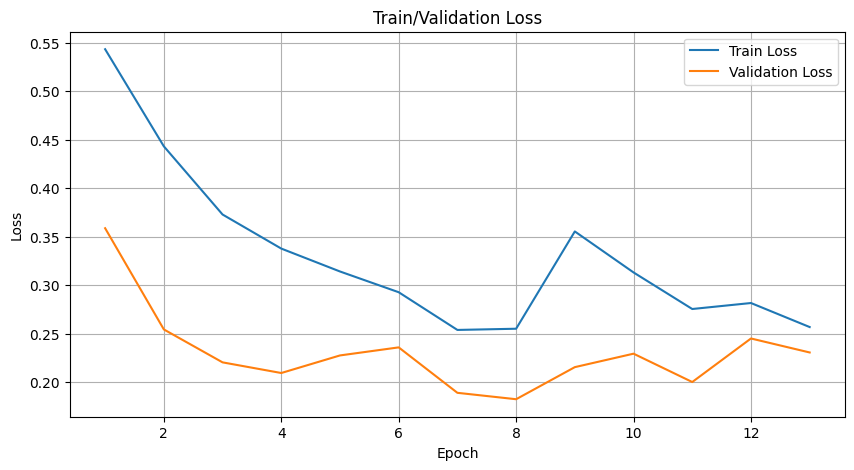

In [5]:
plot_training_history(history)

In [5]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/mortality/resampled_30_datasampler/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

In [6]:
output= test_patient_outcome_model(model, test_loader, device)

241 --- torch.Size([2, 410])
99 --- torch.Size([2, 410])
165 torch.Size([2, 410])
EDGE_INDEX: torch.Size([2, 410])		LOOP_INDEX: torch.Size([2, 165])
241 --- torch.Size([2, 410])
99 --- torch.Size([2, 410])
165 torch.Size([2, 410])
EDGE_INDEX: torch.Size([2, 410])		LOOP_INDEX: torch.Size([2, 165])
241 --- torch.Size([2, 510])
99 --- torch.Size([2, 510])
190 torch.Size([2, 510])
EDGE_INDEX: torch.Size([2, 510])		LOOP_INDEX: torch.Size([2, 190])
241 --- torch.Size([2, 510])
99 --- torch.Size([2, 510])
190 torch.Size([2, 510])
EDGE_INDEX: torch.Size([2, 510])		LOOP_INDEX: torch.Size([2, 190])
241 --- torch.Size([2, 452])
99 --- torch.Size([2, 452])
179 torch.Size([2, 452])
EDGE_INDEX: torch.Size([2, 452])		LOOP_INDEX: torch.Size([2, 179])
241 --- torch.Size([2, 452])
99 --- torch.Size([2, 452])
179 torch.Size([2, 452])
EDGE_INDEX: torch.Size([2, 452])		LOOP_INDEX: torch.Size([2, 179])
241 --- torch.Size([2, 444])
99 --- torch.Size([2, 444])
178 torch.Size([2, 444])
EDGE_INDEX: torch.Size([

- Best threshold: 0.122875154 → F1: 0.6857142807183674
- Total test samples: 461
- Number of actual deaths: 51
- Predictions range: min= 1.4787711e-05  max= 0.9289564
- Mean predicted death probability: 0.06780032
- Test Mortality - AUROC: 0.9346, AUPRC: 0.7138, Precision: 0.6667, Recall: 0.7059,pecificity: 0.9561, F1: 0.6857

241 --- torch.Size([2, 10])
99 --- torch.Size([2, 10])
5 torch.Size([2, 10])
EDGE_INDEX: torch.Size([2, 10])		LOOP_INDEX: torch.Size([2, 5])
241 --- torch.Size([2, 10])
99 --- torch.Size([2, 10])
5 torch.Size([2, 10])
EDGE_INDEX: torch.Size([2, 10])		LOOP_INDEX: torch.Size([2, 5])


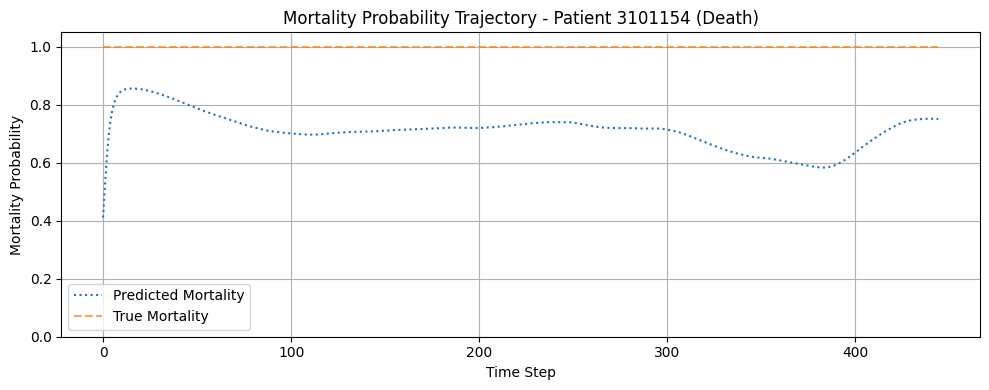

In [7]:
plot_patient_mortality_probability(model, test_loader, patient_index=317, device=device)

241 --- torch.Size([2, 12])
99 --- torch.Size([2, 12])
4 torch.Size([2, 12])
EDGE_INDEX: torch.Size([2, 12])		LOOP_INDEX: torch.Size([2, 4])
241 --- torch.Size([2, 12])
99 --- torch.Size([2, 12])
4 torch.Size([2, 12])
EDGE_INDEX: torch.Size([2, 12])		LOOP_INDEX: torch.Size([2, 4])


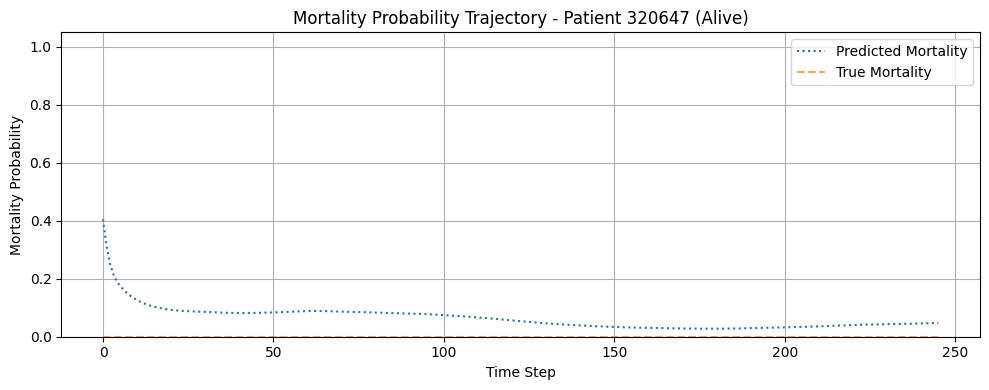

In [8]:
plot_patient_mortality_probability(model, test_loader, patient_index=398, device=device)

In [9]:
from matplotlib.colors import LogNorm
def plot_som_activation_heatmap(heatmap, som_dim, cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        cmap=cmap,
        norm=LogNorm(vmin=max(heatmap.min(), 1e-3), vmax=heatmap.max()),
        annot=False,
        fmt="d",
        square=True,
        cbar_kws={"label": "Activation Count"}
    )
    plt.title("Overall SOM Activation")
    plt.xlabel("SOM Width")
    plt.ylabel("SOM Height")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

241 --- torch.Size([2, 410])
99 --- torch.Size([2, 410])
165 torch.Size([2, 410])
EDGE_INDEX: torch.Size([2, 410])		LOOP_INDEX: torch.Size([2, 165])
241 --- torch.Size([2, 410])
99 --- torch.Size([2, 410])
165 torch.Size([2, 410])
EDGE_INDEX: torch.Size([2, 410])		LOOP_INDEX: torch.Size([2, 165])
241 --- torch.Size([2, 510])
99 --- torch.Size([2, 510])
190 torch.Size([2, 510])
EDGE_INDEX: torch.Size([2, 510])		LOOP_INDEX: torch.Size([2, 190])
241 --- torch.Size([2, 510])
99 --- torch.Size([2, 510])
190 torch.Size([2, 510])
EDGE_INDEX: torch.Size([2, 510])		LOOP_INDEX: torch.Size([2, 190])
241 --- torch.Size([2, 452])
99 --- torch.Size([2, 452])
179 torch.Size([2, 452])
EDGE_INDEX: torch.Size([2, 452])		LOOP_INDEX: torch.Size([2, 179])
241 --- torch.Size([2, 452])
99 --- torch.Size([2, 452])
179 torch.Size([2, 452])
EDGE_INDEX: torch.Size([2, 452])		LOOP_INDEX: torch.Size([2, 179])
241 --- torch.Size([2, 444])
99 --- torch.Size([2, 444])
178 torch.Size([2, 444])
EDGE_INDEX: torch.Size([

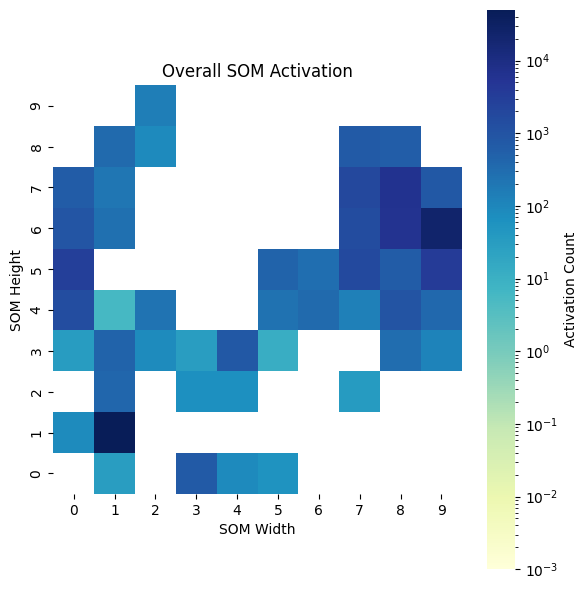

In [10]:
som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)

241 --- torch.Size([2, 410])
99 --- torch.Size([2, 410])
165 torch.Size([2, 410])
EDGE_INDEX: torch.Size([2, 410])		LOOP_INDEX: torch.Size([2, 165])
241 --- torch.Size([2, 410])
99 --- torch.Size([2, 410])
165 torch.Size([2, 410])
EDGE_INDEX: torch.Size([2, 410])		LOOP_INDEX: torch.Size([2, 165])
241 --- torch.Size([2, 510])
99 --- torch.Size([2, 510])
190 torch.Size([2, 510])
EDGE_INDEX: torch.Size([2, 510])		LOOP_INDEX: torch.Size([2, 190])
241 --- torch.Size([2, 510])
99 --- torch.Size([2, 510])
190 torch.Size([2, 510])
EDGE_INDEX: torch.Size([2, 510])		LOOP_INDEX: torch.Size([2, 190])
241 --- torch.Size([2, 452])
99 --- torch.Size([2, 452])
179 torch.Size([2, 452])
EDGE_INDEX: torch.Size([2, 452])		LOOP_INDEX: torch.Size([2, 179])
241 --- torch.Size([2, 452])
99 --- torch.Size([2, 452])
179 torch.Size([2, 452])
EDGE_INDEX: torch.Size([2, 452])		LOOP_INDEX: torch.Size([2, 179])
241 --- torch.Size([2, 444])
99 --- torch.Size([2, 444])
178 torch.Size([2, 444])
EDGE_INDEX: torch.Size([

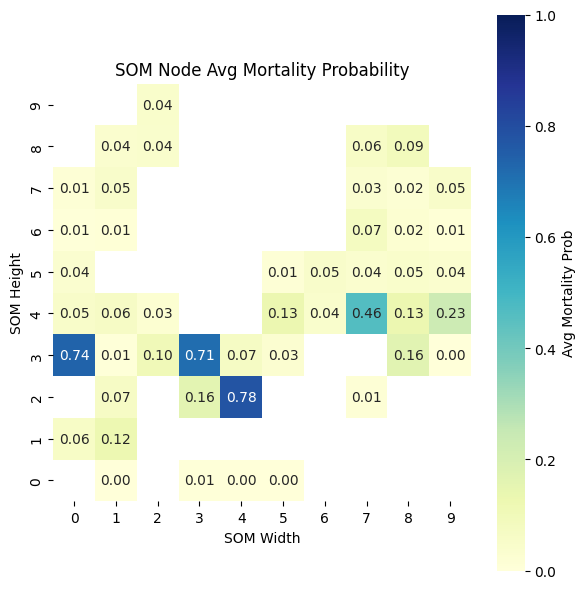

In [11]:
som_dim = (10,10)
mort_heatmap = compute_som_avg_mortality_prob(model, test_loader, device, som_dim)
plot_som_avg_mortality_prob(mort_heatmap, som_dim)

In [ ]:
# best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_smooth/best_joint.pth'
# model2 = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
# model2.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

In [12]:
print_statistics_of_dataloaer(test_loader)

test_loader 中 cat=0 的样本索引： [327, 194, 122, 161, 303, 123, 127, 51, 117, 109, 241, 279, 48, 61, 53, 302, 18, 114, 131, 77, 75, 88, 46, 43, 418, 71, 330]
cat=0 的患者 ID: [3118263, 2441148, 1848702, 2235716, 3064491, 1849239, 1854497, 1721495, 1842081, 1822777, 2642496, 2851573, 1718669, 1730209, 1722941, 3063135, 1334230, 1833798, 1857925, 1764355, 1762378, 1788553, 1364166, 1358338, 3232813, 1754475, 3123772]
cat=0 的样本长度: [475, 246, 152, 145, 80, 79, 58, 57, 55, 49, 49, 49, 48, 48, 47, 47, 44, 44, 44, 43, 42, 41, 39, 36, 36, 35, 32]
test_loader 中 cat=1 的样本索引： [15, 235, 28, 286, 267, 326, 98, 188, 334, 380, 52, 331, 240, 273, 352, 423, 56, 70, 42, 391, 179, 377, 217, 103, 140, 269, 356, 40, 76, 236, 408, 97, 130, 416, 315, 99, 208, 0, 372, 407, 319, 102, 126, 378, 347, 409, 219, 313, 368, 92, 72, 417, 111, 403, 447, 289, 31, 178, 81, 390, 229, 67, 115, 184, 3, 263, 419, 277, 439, 294, 274, 437, 268, 54, 264, 354, 259, 388, 191, 124, 311, 340, 233, 255, 105, 299, 246, 73, 5, 26, 35, 116, 1,

In [13]:
# --- 1. 计算热力图 ---
som_dim = (10,10)
mort_heatmap = compute_som_avg_mortality_prob(model, test_loader, device, som_dim)

241 --- torch.Size([2, 410])
99 --- torch.Size([2, 410])
165 torch.Size([2, 410])
EDGE_INDEX: torch.Size([2, 410])		LOOP_INDEX: torch.Size([2, 165])
241 --- torch.Size([2, 410])
99 --- torch.Size([2, 410])
165 torch.Size([2, 410])
EDGE_INDEX: torch.Size([2, 410])		LOOP_INDEX: torch.Size([2, 165])
241 --- torch.Size([2, 510])
99 --- torch.Size([2, 510])
190 torch.Size([2, 510])
EDGE_INDEX: torch.Size([2, 510])		LOOP_INDEX: torch.Size([2, 190])
241 --- torch.Size([2, 510])
99 --- torch.Size([2, 510])
190 torch.Size([2, 510])
EDGE_INDEX: torch.Size([2, 510])		LOOP_INDEX: torch.Size([2, 190])
241 --- torch.Size([2, 452])
99 --- torch.Size([2, 452])
179 torch.Size([2, 452])
EDGE_INDEX: torch.Size([2, 452])		LOOP_INDEX: torch.Size([2, 179])
241 --- torch.Size([2, 452])
99 --- torch.Size([2, 452])
179 torch.Size([2, 452])
EDGE_INDEX: torch.Size([2, 452])		LOOP_INDEX: torch.Size([2, 179])
241 --- torch.Size([2, 444])
99 --- torch.Size([2, 444])
178 torch.Size([2, 444])
EDGE_INDEX: torch.Size([

--- Searching for specified patient IDs: ['2441148'] ---


Searching for patients:  27%|██▋       | 4/15 [00:00<00:00, 36.37it/s]

  -> Found 1 target(s) in batch. Forward pass...
241 --- torch.Size([2, 670])
99 --- torch.Size([2, 670])
221 torch.Size([2, 670])
EDGE_INDEX: torch.Size([2, 670])		LOOP_INDEX: torch.Size([2, 221])
241 --- torch.Size([2, 670])
99 --- torch.Size([2, 670])


Searching for patients:  40%|████      | 6/15 [00:00<00:00, 21.66it/s]


221 torch.Size([2, 670])
EDGE_INDEX: torch.Size([2, 670])		LOOP_INDEX: torch.Size([2, 221])
    -> Trajectory for ID=2441148, category=0, mortality=0
--- All targets found. ---

Plotting trajectory snapshots at timesteps: [245]


/home/mei/nas/docker/thesis/model_train/model/final_model/mortality/plot.py:458: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.7, 0.96])


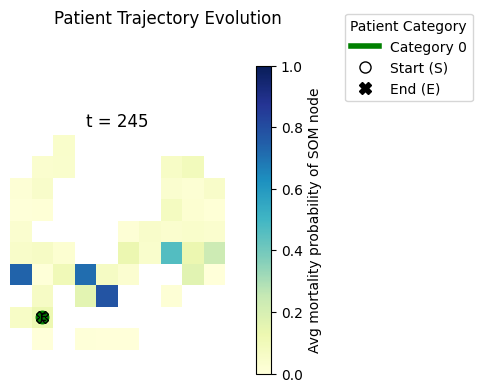

In [14]:
patient_ids = ['2441148'] 
# 2441148, 1848702, 1848702, 1848702, 1848702, 2235716,
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=mort_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['3120701'] ---


Searching for patients:  53%|█████▎    | 8/15 [00:00<00:00, 35.51it/s]

  -> Found 1 target(s) in batch. Forward pass...
241 --- torch.Size([2, 412])
99 --- torch.Size([2, 412])
160 torch.Size([2, 412])
EDGE_INDEX: torch.Size([2, 412])		LOOP_INDEX: torch.Size([2, 160])
241 --- torch.Size([2, 412])
99 --- torch.Size([2, 412])
160 torch.Size([2, 412])
EDGE_INDEX: torch.Size([2, 412])		LOOP_INDEX: torch.Size([2, 160])
    -> Trajectory for ID=3120701, category=3, mortality=1
--- All targets found. ---


Searching for patients:  67%|██████▋   | 10/15 [00:00<00:00, 19.51it/s]
/home/mei/nas/docker/thesis/model_train/model/final_model/mortality/plot.py:458: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.7, 0.96])



Plotting trajectory snapshots at timesteps: [330]


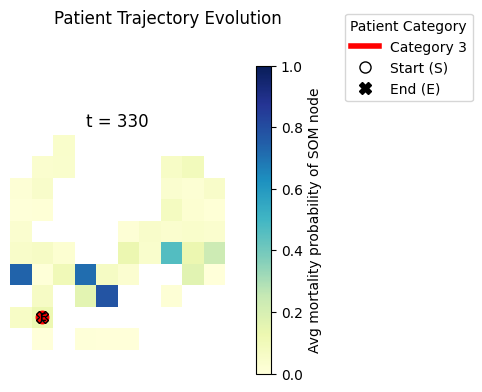

In [15]:
patient_ids = ['3120701'] 
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=mort_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)